# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Required:

- python
- obspy (and its dependencies)
- pandas
- jupyter
- notebook
- tqdm

this should be easy to set up in a conda env: ``conda create -c conda-forge -n covid python=3.7 obspy pandas jupyter notebook tqdm``

Author: Thomas Lecocq @seismotom, Fred Massin @fmassin, Claudio Satriano @claudiodsf

## Step 1: imports

In [22]:
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
import seismosocialdistancing_core as seismosocialdistancing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [24]:
## The station information is provided in a file called `seismosocialdistancing_settings.py 

import seismosocialdistancing_settings as ssd

start = ssd.start
end = ssd.end
safety_window = ssd.safety_window

network   = ssd.network
station   = ssd.station
location  = ssd.location
channel   = ssd.channel
dataset   = ssd.dataset
time_zone = ssd.time_zone
sitedesc  = ssd.sitedesc

data_provider = ssd.data_provider
logo = ssd.logo
bans = ssd.bans

datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")

# This is the current date in pandas format
today = pd.to_datetime(UTCDateTime.now().date)


datetime.datetime(2020, 12, 1, 0, 0)

## Step 3: Download the seismic waveform data

This step is coded so that only the last day is redownloaded if the daily files are present on the disk.

The request gets the target day +- 30 minutes to avoid having gaps at the end of each day (need 1 window covering midnight).

In [66]:
force_reprocess = False

import pathlib
pathlib.Path(os.path.join("..","data")).mkdir(parents=True, exist_ok=True)

c = Client(data_provider)

nslc = "{}.{}.{}.{}".format(network, station, location, channel)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")
pbar = tqdm.tqdm(datelist)
goodday=None

for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn  = os.path.join("..","workdir","{}_{}_{}.mseed".format(dataset, datestr, nslc))
    fnz = os.path.join("..","data","{}_{}_{}.npz".format(dataset, datestr, nslc))
    
    if (today-day > safety_window) and (os.path.isfile(fn) or (os.path.isfile(fnz) and not force_reprocess)):
        pbar.set_description("Using cache - %s" % fn)
        goodday = day
        continue
    else:
        pbar.set_description("Fetching    - %s" % fn)
        try: 
            st = c.get_waveforms(network, station, location, channel,
                                  UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801,
                                  attach_response=True)
            goodday=day
        except FDSNNoDataException:
            pbar.set_description("No data on FDSN server for %s" % fn)
            continue
        st.write(fn)

# This is to ensure that we get recent information but allow fallback to earlier dates 

for day in datelist[::-1]:  
    try:
        resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
        print("Response for date: {}".format(day))
        print(resp)
        break
    except:
        print("Exception for date: {}".format(day))
        pass




No data on FDSN server for ../workdir/AuSiS_Canberra_2020-06-08_S1.AUDAR..HHZ.mseed: 100%|██████████| 69/69 [00:06<00:00, 11.07it/s]
Response for date: 2020-06-08 00:00:00
Inventory created at 2020-06-10T03:30:44.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2020-06-08...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			S1
		Stations (1):
			S1.AUDAR (Daramalan College)
		Channels (1):
			S1.AUDAR..HHZ


In [67]:
st = c.get_waveforms(network, station, location, channel,
                                  UTCDateTime(goodday)-1801, UTCDateTime(goodday)+86400+1801,
                                  attach_response=True)

## Step 4: Compute PPSDs using custom parameters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [68]:

pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_in = os.path.join("..","workdir","{}_{}_{}.mseed".format(dataset, datestr, nslc))
    pbar.set_description("Processing %s" % fn_in)
    if not os.path.isfile(fn_in):
        continue
    stall = read(fn_in, headonly=True)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = os.path.join("..","data","{}_{}_{}.npz".format(dataset, datestr, mseedid))
        if (today-day > safety_window) and (os.path.isfile(fn_out) and not force_reprocess):
            continue
        st = read(fn_in, sourcename=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        del st, ppsd
    del stall

Processing ../workdir/AuSiS_Canberra_2020-06-08_S1.AUDAR..HHZ.mseed: 100%|██████████| 69/69 [00:05<00:00, 12.53it/s]


## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [69]:
ppsds = {}
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_pattern = os.path.join("..","data","{}_{}_*.npz".format(dataset, datestr))
    pbar.set_description("Reading %s" % fn_pattern)
    for fn in glob(fn_pattern):
        mseedid = fn.replace(".npz", "").split("_")[-1]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn)#, allow_pickle=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ppsds[mseedid].add_npz(fn)#, allow_pickle=True)

Reading ../data/AuSiS_Canberra_2020-06-08_*.npz: 100%|██████████| 69/69 [00:01<00:00, 42.16it/s]


## Step 6: Standard plots:

In [ ]:
[ppsd.plot(max_percentage=10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_spectrogram(clim=(-160,-100)) for mseedid, ppsd in ppsds.items()]

## Step 7: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [ ]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]

displacement_RMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
    data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
    data = data.sort_index(axis=1)
    displacement_RMS[mseedid] = seismosocialdistancing.df_rms(data, freqs, output="DISP")
    # displacement_RMS[mseedid].to_csv(os.path.join("..", "results", "%s.csv" % mseedid))
    displacement_RMS[mseedid].to_csv(os.path.join("..", "results", "latest.csv"))

## Weekday / Time of day Analysis

In [ ]:
args = {'band':"4.0-14.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo':logo,             # might be None or commented
        'bans':bans,             # might be None or commented
        'save':'../results/',    # might be None or commented or a path 
        'unit':'nm',
        'format':'png',
        'show':True,
        'basename':"../results/latest"      # to over-ride the default name
       }

seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

In [ ]:
seismosocialdistancing.plot(displacement_RMS,
                            type='dailyplots',
                            **args)

In [52]:
seismosocialdistancing.plot(displacement_RMS,
                            type='clockplots',
                            **args)

KeyError: "None of [Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',\n       'Sunday'],\n      dtype='object')] are in the [columns]"

## Noise distribution over time of the day  

No handles with labels found to put in legend.


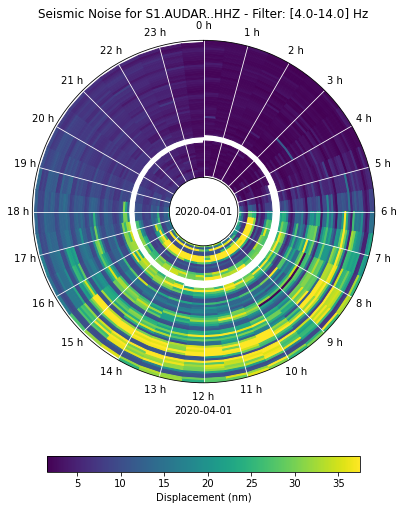

In [53]:
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

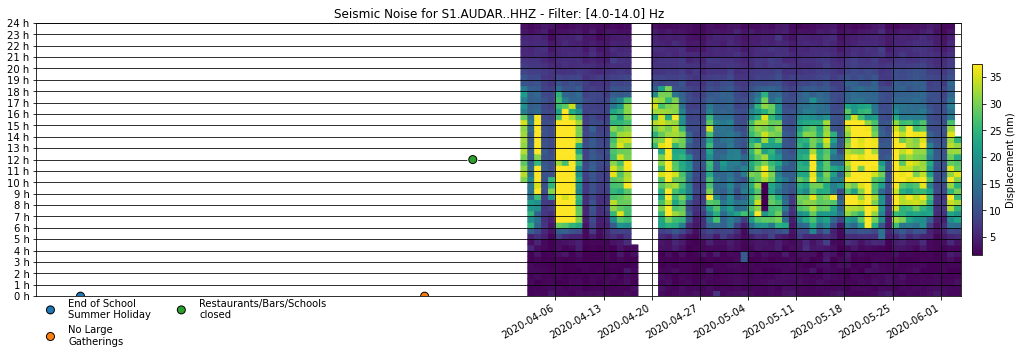

In [54]:
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)

## Temporary code: All your stations' colormapped plot

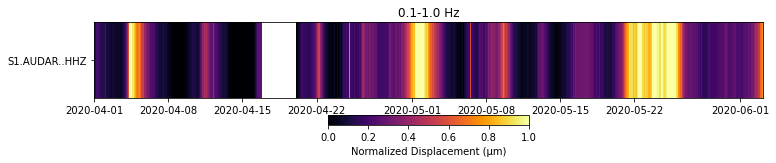

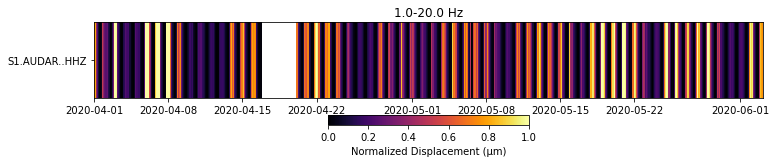

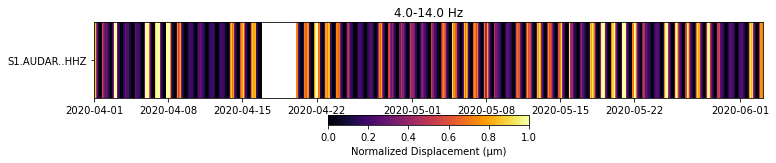

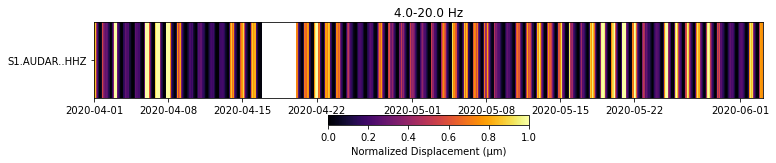

In [48]:
normalize = True
resample_freq = "1H"
clip = (0.05,0.95)

#concatenating in a single dataframe and converting to nm
dRMS2D = pd.concat(displacement_RMS, axis=0) * 1e9
for band in dRMS2D.columns:
    g = dRMS2D.loc[:,band].unstack().T
    g = g.clip(g.quantile(clip[0]),g.quantile(clip[1]),axis=1)
    g = g.resample(resample_freq).median()
    if normalize:
        g -= g.quantile(0.01)
        g /= g.quantile(0.99)
        vmin, vmax = 0, 1
    else:
        vmin = vmax = None
   
    fig, ax = plt.subplots(1,1, figsize=(12,2*len(g.columns)))
    label = '%sDisplacement (µm)' % ["","Normalized "][normalize]

    x = np.append(g.index.values, g.index.shift(1).values[-1])
    y = np.append(g.columns, "")
    plt.pcolormesh(x, y, g.T,  cmap="inferno", vmin=vmin, vmax=vmax)
    plt.colorbar(orientation='horizontal', shrink=0.3).set_label(label)
    pos, l = plt.yticks()
    plt.yticks(np.asarray(pos)+0.5, y)
    plt.margins(0)
    plt.title("%s Hz" % band)
    plt.gca().invert_yaxis()
    plt.show()